In [1]:
from PIL import Image
import torchvision.transforms as T
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def get_image_transform(
    image_size = (256, 256),
    mean = (0.485, 0.456, 0.406),
    std= (0.229, 0.224, 0.225),
):
    tfs = []
    tfs.append(T.Resize(image_size))
    tfs.append(T.ToTensor())
    tfs.append(T.Normalize(mean, std))
    return T.Compose(tfs)

In [18]:
def plot(orig_img, imgs, with_orig=True, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [2]:
image_path = '/mnt/workspace/iu-x-ray/dataset/images/CXR2593_IM-1084-1001.png'

In [3]:
img = Image.open(image_path)

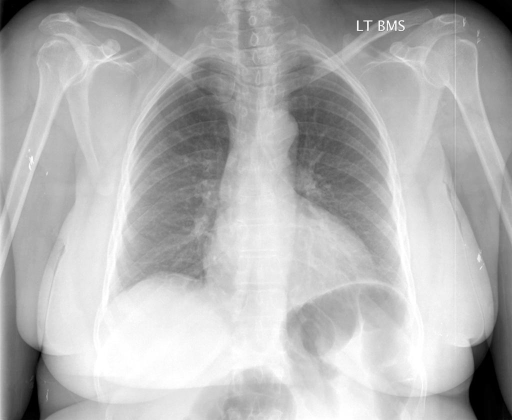

In [4]:
img.convert('RGB')

In [11]:
transform = get_image_transform()

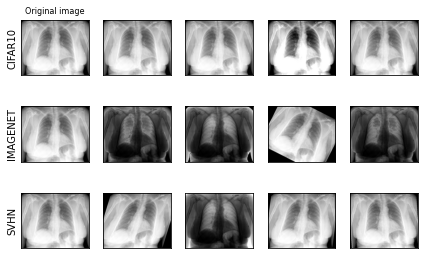

In [19]:
policies = [T.AutoAugmentPolicy.CIFAR10, T.AutoAugmentPolicy.IMAGENET, T.AutoAugmentPolicy.SVHN]
augmenters = [T.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(img) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot(img, imgs, row_title=row_title)

In [85]:
def get_augmentation_transforms(image_size,
                                crop=0.8, translate=0.1, rotation=15, contrast=0.8, brightness=0.8,
                                shear=(10, 10), noise_gaussian=0.1):
    shear_x, shear_y = shear
    contrast_down_max = 0.97
    contrast_up_min = 1.03
    brightness_down_max = 0.97
    brightness_up_min = 1.02
    
    transforms = [
        T.RandomResizedCrop(
            image_size,
            scale=(crop, 1),
        ),
        T.RandomAffine(
            degrees=0,
            translate=(translate, translate),
        ),
        T.RandomAffine(
            degrees=0,
            shear=(-shear_x, shear_x, -shear_y, shear_y),
        ),        
        T.RandomRotation(15),
        T.ColorJitter(
            contrast=(contrast_down_max - contrast, contrast_down_max),
        ),
        T.ColorJitter(
            contrast=(contrast_up_min, contrast_up_min + contrast),
        ),
        T.ColorJitter(
            brightness=(brightness_down_max - brightness, brightness_down_max),
        ),
        T.ColorJitter(
            brightness=(brightness_up_min, brightness_up_min + brightness),
        ),
    ]
    
    return transforms

In [98]:
transforms = get_augmentation_transforms((256, 256))

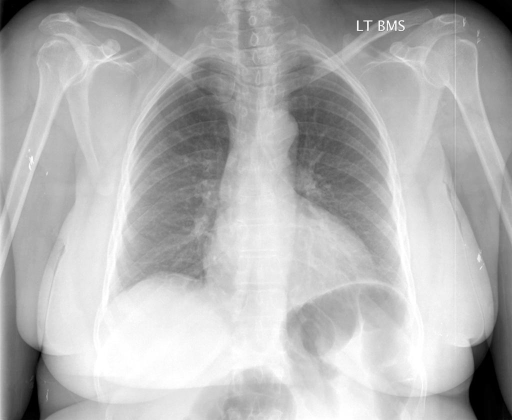

In [30]:
img

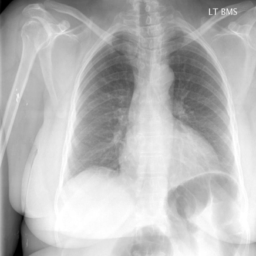

In [99]:
transforms[0](img)

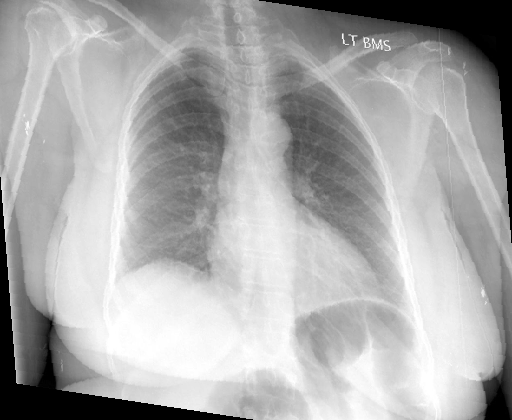

In [93]:
transforms[2](img)

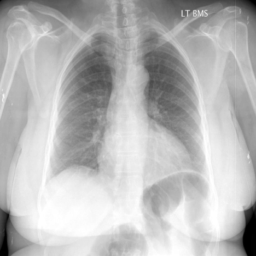

In [32]:
transforms[0](img)

In [5]:
from medvqa.datasets.augmentation import ImageAugmentationTransforms

In [6]:
img_aug_trans = ImageAugmentationTransforms((256, 256))

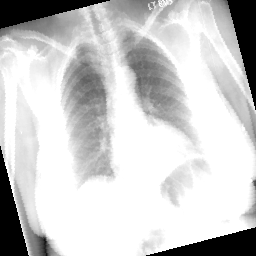

In [35]:
img_aug_trans.get_color_transforms()[3](img_aug_trans.get_spatial_transforms()[2](T.Resize((256, 256))(img.convert('RGB'))))

In [2]:
import albumentations as A
import torchvision.transforms as T
import cv2
import matplotlib.pyplot as plt

In [3]:
from medvqa.datasets.augmentation import ImageAugmentationTransforms

In [4]:
def get_transforms(img_size=416):
    tf_load_image = lambda x: cv2.imread(x)
    tf_bgr2rgb = lambda x: cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    iat = ImageAugmentationTransforms(image_size=img_size)
#     tf_aug_train = A.Compose([
#         A.CLAHE(p=1.0),
#         A.Equalize(p=0.5),
#         A.RandomResizedCrop(height=img_size, width=img_size, scale=(0.8, 1.0), p=1.0),
#         A.HorizontalFlip(p=0.5),
#         A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5),
#         A.CoarseDropout(max_holes=8, max_height=32, max_width=32, p=0.2),
#         A.GaussianBlur(blur_limit=(3, 7), p=0.2),
#         A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
#         A.Equalize(p=0.5),
#         A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#         ToTensorV2()
#     ])
    tf_aug_train = iat.get_train_transform('both')
#     tf_aug_test = A.Compose([
#         A.Equalize(p=1.0),
#         A.CLAHE(p=1.0),
#         A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=1.0),
#         A.Resize(img_size, img_size),
#         A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#         ToTensorV2()
#     ])
    tf_aug_test = iat.get_test_transform()
    
    def transform_train(image_path):
        image = tf_load_image(image_path)
        image = tf_bgr2rgb(image)
        image = tf_aug_train(image=image)
        return image
    
    def transform_test(image_path):
        image = tf_load_image(image_path)
        image = tf_bgr2rgb(image)
        image = tf_aug_test(image=image)
        return image

    return transform_train, transform_test

In [5]:
transform_train, transform_test = get_transforms()

In [6]:
from medvqa.datasets.iuxray import get_invalid_images, get_iuxray_image_path
from IPython.display import Image

In [7]:
iuxray_invalid_images = get_invalid_images()

In [8]:
iuxray_invalid_images = list(iuxray_invalid_images)

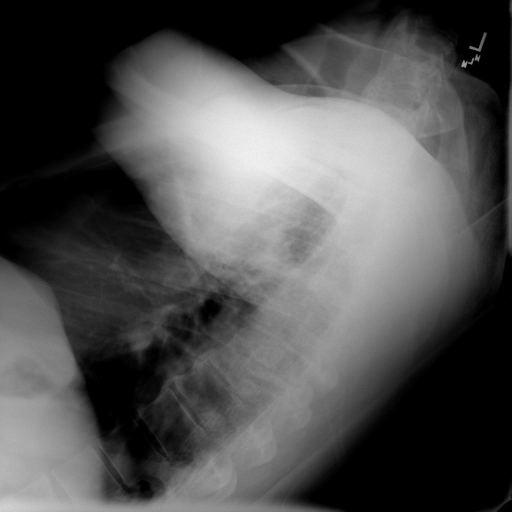

In [11]:
Image(get_iuxray_image_path(iuxray_invalid_images[14]))

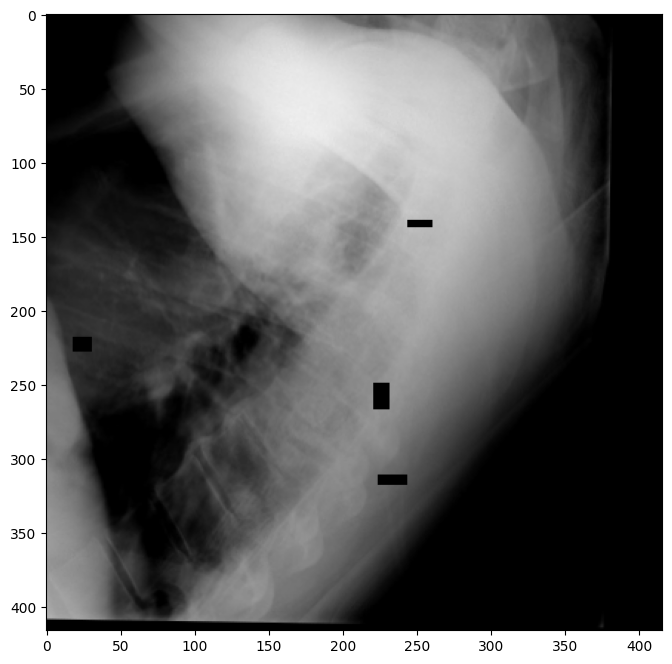

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(transform_train(get_iuxray_image_path(iuxray_invalid_images[14]))['image'])
plt.show()